###1. Mount the Google Drive and Import Libraries.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
# To make directory
import os
# To read the JSONL File and get the Train-Test Split
import json
# To create images with the specified Train-Test Split
import shutil
import tensorflow as tf
import torch
import torchvision.models as models
import matplotlib.pyplot as plt

In [3]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import BinaryAccuracy, Precision, Recall
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dropout,Activation
from tensorflow.keras.layers import Dense
from keras.layers import BatchNormalization
from keras.models import Model, Sequential
from keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from tensorflow.keras.applications import ResNet50

In [4]:
import tensorflow as tf
print(tf.__version__)

2.12.0


In [5]:
#from google.colab import drive
#drive.mount('/content/drive')
import tensorflow as tf
if tf.test.gpu_device_name():
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))
else:
    print("Please install GPU version of TF")

Please install GPU version of TF


In [6]:
# Add the Source path as the path of the ZIP File
zip_src_path = '/content/drive/MyDrive/DL/Assignments/A4/hateful_memes.zip'
# Add the Destination path as the path of the ZIP File
zip_dest_path = '/content/drive/MyDrive/DeepLearning/meme_master'

###2. Get the Dataset and Data Generators. Create the Train / Validation and Test Set splits from the given JSON Data.

In [7]:
check_var = 1
# Check if the target directory already exists at the specified path or not
if not os.path.exists(zip_dest_path):
  os.makedirs(zip_dest_path)
  print("The Directory is created.")
else:
  check_var = 0
  print("The Directory already exists.")

The Directory already exists.


In [8]:
# Unzip the ZIP FOLDER
if check_var==1 :
  !unzip $zip_src_path  -d $zip_dest_path
else:
  print('Alredy Unzipped.')

Alredy Unzipped.


In [9]:
# Get  the List of Contents in the unzipped folder.
target_dir = zip_dest_path+'/hateful_memes'
# Get the list of files and directories in the specified directory
files = os.listdir(target_dir)
# Print the list of files and directories
for file in files:
    print(file)

dev_seen.jsonl
test_seen.jsonl
test_unseen.jsonl
dev_unseen.jsonl
train.jsonl
README.md
LICENSE.txt
.DS_Store
img


In [10]:
# Set the file path for each relevant directory
train_json = target_dir + '/train.jsonl'
val_json = target_dir + '/dev_seen.jsonl'
test_json = target_dir + '/test_seen.jsonl'

In [11]:
# Open the JSONL file to read the Data to a Pandas Dataframe
def get_df_from_json(path):
    with open(path, 'r') as f:
        file_data = f.readlines()

    # Parse each JSON object and store them in a list
    data = []
    for d in file_data:
        data.append(json.loads(d))

    # Convert the list of JSON objects to a DataFrame
    df = pd.DataFrame(data)
    
    return df

In [12]:
train_json_df = get_df_from_json(train_json)
val_json_df = get_df_from_json(val_json)
test_json_df = get_df_from_json(test_json)

In [13]:
train_json_df

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."
...,...,...,...,...
8495,10423,img/10423.png,1,nobody wants to hang auschwitz me
8496,98203,img/98203.png,1,when god grants you a child after 20 years of ...
8497,36947,img/36947.png,1,gays on social media: equality! body positivit...
8498,16492,img/16492.png,1,having a bad day? you could be a siamese twin ...


In [14]:
val_json_df

,id,img,label,text
0,08291,img/08291.png,1,white people is this a shooting range
1,46971,img/46971.png,1,bravery at its finest
2,03745,img/03745.png,1,your order comes to $37.50 and your white priv...
3,83745,img/83745.png,1,it is time.. to send these parasites back to t...
4,80243,img/80243.png,1,mississippi wind chime
...,...,...,...,...
495,83675,img/83675.png,0,i'm gonna be like phelps one day
496,37198,img/37198.png,0,when you're so relaxed you can feel yourself g...
497,48670,img/48670.png,0,look at this sandwich maker club i found on wi...
498,09863,img/09863.png,0,diverse group of women


In [15]:
test_json_df

,id,img,label,text
0,16395,img/16395.png,1,handjobs sold seperately
1,37405,img/37405.png,1,introducing fidget spinner for women
2,94180,img/94180.png,1,happy pride month let's go beat up lesbians
3,54321,img/54321.png,1,laughs in [majority of u.s crime rate]
4,97015,img/97015.png,1,finds out those 72 virgins.. are goats
...,...,...,...,...
995,03869,img/03869.png,0,a mother's love for the child is a divine thing
996,23817,img/23817.png,0,sea monkeys
997,56280,img/56280.png,0,little miss muffet sat on her tuffet
998,29384,img/29384.png,0,they're in a row


In [16]:
train_ids = train_json_df['id'].tolist()
for i in range(len(train_ids)):
  train_ids[i]= str(train_ids[i])+'.png'

In [17]:
print(train_ids)

['42953.png', '23058.png', '13894.png', '37408.png', '82403.png', '16952.png', '76932.png', '70914.png', '02973.png', '58306.png', '79351.png', '34096.png', '25489.png', '19324.png', '79346.png', '13426.png', '97628.png', '14238.png', '28936.png', '59784.png', '02146.png', '70146.png', '28061.png', '97180.png', '49752.png', '25610.png', '15872.png', '72640.png', '64318.png', '17956.png', '93547.png', '10743.png', '37091.png', '25719.png', '76825.png', '72598.png', '43078.png', '51846.png', '01569.png', '95812.png', '06418.png', '53976.png', '70193.png', '60427.png', '78395.png', '04876.png', '92075.png', '86354.png', '74386.png', '59613.png', '10263.png', '48279.png', '52610.png', '58371.png', '27401.png', '89574.png', '25473.png', '47913.png', '08295.png', '02497.png', '90471.png', '69357.png', '54602.png', '15320.png', '63182.png', '20619.png', '82457.png', '81059.png', '42137.png', '74530.png', '40832.png', '46127.png', '87594.png', '12548.png', '12894.png', '02476.png', '06937.png'

In [18]:
# Get the Image IDs corresponding to the ID-Column in the DataFrame for Train Set
train_lst = (train_json_df['img']).tolist()
train_labels = (train_json_df['label']).tolist()
print(len(train_lst))
print(len(train_labels))

8500
8500


In [19]:
# Get the Image IDs corresponding to the ID-Column in the DataFrame for Validation Set
val_lst = (val_json_df['img'].tolist())
val_labels = (val_json_df['label']).tolist()
print(len(val_lst))
print(len(val_labels))

500
500


In [20]:
# Get the Image IDs corresponding to the ID-Column in the DataFrame for Test Set
test_lst = (test_json_df['img'].tolist())
test_labels = (test_json_df['label']).tolist()
print(len(test_lst))
print(len(test_labels))

1000
1000


In [21]:
def set_data():
    # Define the three lists of IDs and their corresponding labels
    id_list_1 = train_lst
    label_list_1 = train_labels
    id_list_2 = val_lst
    label_list_2 = val_labels
    id_list_3 = test_lst
    label_list_3 = test_labels

    # Loop over the three ID lists and process each one
    for i, (id_list, label_list) in enumerate([(id_list_1, label_list_1), (id_list_2, label_list_2), (id_list_3, label_list_3)]):
        # Create a new directory for this ID list in the output directory
        subdir_path = os.path.join(output_dir, f'subdir_{i+1}')
        os.makedirs(subdir_path, exist_ok=True)
        print(f' For subdir_{i+1}')
        # Create two subdirectories for each output directory based on the label
        subsubdir_path_1 = os.path.join(subdir_path, 'label_0')
        subsubdir_path_2 = os.path.join(subdir_path, 'label_1')
        # Create the Directories
        os.makedirs(subsubdir_path_1, exist_ok=True)
        os.makedirs(subsubdir_path_2, exist_ok=True)
        # Loop over the IDs in this list and copy the corresponding images to the appropriate subdirectory
        for j, img_id in enumerate(id_list):
            # Construct the path to the image file based on the ID
            img_path = os.path.join(input_dir, img_id)
            print(f"Processing Image - {j}")
            # Check if the image file exists and copy it to the appropriate subdirectory based on the label
            if os.path.isfile(img_path):
                label = label_list[j]
                if label == 0:
                    shutil.copy(img_path, subsubdir_path_1)
                else:
                    shutil.copy(img_path, subsubdir_path_2)


In [22]:
# # Set the paths to the input directory and the output directory
# input_dir = target_dir
# output_dir = '/content/drive/MyDrive/DL/Assignments/A4/Image_Data'

# if not os.path.exists(output_dir):
#     os.makedirs(output_dir)
#     set_data()
# else:
#   print('The Data exists in the appropriate form for the Data Generators')

###3. Pre-processing the Dataset



In [23]:
# Define the paths to the train, validation, and test directories
train_dir = '/content/drive/MyDrive/DL/Assignments/A4/Image_Data/subdir_1'
val_dir = '/content/drive/MyDrive/DL/Assignments/A4/Image_Data/subdir_2'
test_dir = '/content/drive/MyDrive/DL/Assignments/A4/Image_Data/subdir_3'

# Define the batch size for the data generators
batch_size = 64

# Define the image data generators for the train, validation, and test sets
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    # horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    # channel_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    shear_range=0.2,
    #validation_split=0.6
    #contrast_stretching=True,
)

val_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    # horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    # channel_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    shear_range=0.2
                                 
    )
                                 
test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    # horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    # channel_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    shear_range=0.2
)
sample_test_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    # horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    # channel_shift_range=0.2,
    brightness_range=[0.5, 1.5],
    shear_range=0.2
    
)

# Use the flow_from_directory method to create the data generators for the train, validation, and test sets
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary',
    subset='training',
)

val_generator = val_datagen.flow_from_directory(
    val_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=batch_size,
    class_mode='binary'
)

Found 8500 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


### 4. Visualise the images after pre-processing.

In [68]:
classes = train_generator.class_indices
classes = dict((v,k) for k,v in classes.items())
# classes = [classes[k] for k in classes]
classes

{0: 'label_0', 1: 'label_1'}

In [69]:
labels = train_generator.class_indices.values()

In [70]:
print(labels)

dict_values([0, 1])


In [71]:
def get_class_plot(generator_class):
    for label in labels:
        print("Class label:", label)
        images = generator_class.next()[0]
        #plt.title("Visualise the Images in {} set".format(generator_class))
        plt.figure(figsize=(10, 10))
        for i in range(5):
            plt.subplot(5, 5, i+1)
            plt.imshow(images[i])
            plt.axis('off')
        plt.show()

In [ ]:
print("For Training Data")
get_class_plot(train_generator)
print("For Validation Data")
get_class_plot(val_generator)
print("For Testing Data")
get_class_plot(test_generator)

For Training Data
Class label: 0


### Code to verify the total images in the Training Directory and add the images which do not exist in the directory as the files are not present in the dicitonary.

In [ ]:
directory = '/content/drive/MyDrive/DL/Assignments/A4/Image_Data/subdir_1/label_0'  # Replace with the path to your directory here.
count = 0
for filename in os.listdir(directory):
    if os.path.isfile(os.path.join(directory, filename)):
        if filename in train_ids:
          train_ids.remove(filename)
        count += 1

print(f'The directory "{directory}" contains {count} files.')

In [ ]:
directory = '/content/drive/MyDrive/DL/Assignments/A4/Image_Data/subdir_1/label_1'  # Replace with the path to your directory here.

for filename in os.listdir(directory):
    if os.path.isfile(os.path.join(directory, filename)):
      if filename in train_ids:
        train_ids.remove(filename)
        #print(filename)
      count += 1

print(f'The directory "{directory}" contains {count} files.')

In [ ]:
print(train_ids)

In [ ]:
# Get back the IDS,
for i in range(len(train_ids)):
  part = train_ids[i].partition(".")
  train_ids[i] = part[0]

In [ ]:
print(train_ids)

In [ ]:
temp_label = []
for i in range(len(train_ids)):
  temp_train_json_df = train_json_df[train_json_df['id'] == train_ids[i]]
  temp_label.append(int(temp_train_json_df['label']))

In [ ]:
print(temp_label)

In [ ]:
subdir_path = '/content/drive/MyDrive/DL/Assignments/A4/Image_Data/subdir_1'
subsubdir_path_1 = os.path.join(subdir_path, 'label_0')
subsubdir_path_2 = os.path.join(subdir_path, 'label_1')

In [ ]:
input_dir = '/content/drive/MyDrive/DeepLearning/meme_master/hateful_memes/img/'
for j, img_id in enumerate(train_ids):
            img_id = str(img_id) + '.png'
            # Construct the path to the image file based on the ID
            img_path = os.path.join(input_dir + img_id)
            print(f"Processing Image - {j}")
            print(img_path)
            # Check if the image file exists and copy it to the appropriate subdirectory based on the label
            if os.path.isfile(img_path):
                label = temp_label[j]
                if label == 0:
                    shutil.copy(img_path, subsubdir_path_1)
                else:
                    shutil.copy(img_path, subsubdir_path_2)

In [ ]:
train_ids

In [ ]:
directory = '/content/drive/MyDrive/DeepLearning/meme_master/hateful_memes/img'  # Replace with the path to your directory here.
count = 0
for filename in os.listdir(directory):
    if os.path.isfile(os.path.join(directory, filename)):
      if filename in train_ids:
        train_ids.remove(filename)
        count += 1

print(f'The directory "{directory}" contains {count} files.')

###5. Model Design and Architecture

In [24]:
# Define the metrics and loss function to use . The metrics being used here are Accuracy, Precision, Recall and F-1 Score
# my_metrics = [
#     BinaryAccuracy(name='Accuracy'),
#     Precision(name='Precision'),
#     Recall(name='Recall'),
#     # Define F1 score as a custom metric using precision and recall
#     lambda y_true, y_pred: 2 * ((y_true * y_pred).sum() / (y_true.sum() + y_pred.sum() + 1e-7))
# ]

In [42]:
# Define the F-1 Score as Evaluation Metric
# Reference - 
def get_f1_score(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [43]:
METRICS = [
      tf.keras.metrics.BinaryAccuracy(name='accuracy'),
      tf.keras.metrics.Precision(name='precision'),
      tf.keras.metrics.Recall(name='recall'),  
      tf.keras.metrics.AUC(name='auc'),
        get_f1_score
]

In [44]:
#my_loss = BinaryCrossentropy()

In [45]:
lrd = ReduceLROnPlateau(monitor = 'val_loss',patience = 15,verbose = 1,factor = 0.20, min_lr = 1e-10)
es = EarlyStopping(verbose=1, patience=5)

In [46]:
# Define the Datasets, corresponding to the given iterators used to fit the model with the given models and validate the result.
train_Dataset = train_generator
valid_Dataset = val_generator
test_Dataset = test_generator

In [49]:
# Get all the Labels for each training examples in the Train Dataset
train_labels = train_generator.classes
val_labels = val_generator.classes
test_labels = test_generator.classes

In [50]:
print(train_labels.shape[0])
print(test_labels.shape[0])
print(val_labels.shape[0])

8500
1000
500


###5.1 ResNet

In [24]:
!pip install tensorflow-addons

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 591.0/591.0 kB 14.5 MB/s eta 0:00:00


In [25]:
import tensorflow_addons as tfa

/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [26]:
from sklearn.utils.class_weight import compute_class_weight

In [27]:
# class_weights = compute_class_weight(
#                                         class_weight = "balanced",
#                                         classes = np.unique(train_labels),
#                                         y = train_labels                                                   
#                                     )
# class_weights = dict(zip(np.unique(train_labels), class_weights))
# class_weights

In [28]:
# Compute the class weights as a dictionary
unique, counts = np.unique(train_labels, return_counts=True)
class_weights = dict(zip(unique, counts / len(train_labels)))

In [29]:
sample_weights = []

In [30]:
# Compute the sample weights as a list
sample_weights = [class_weights[label] for label in train_labels]

In [31]:
print(sample_weights)

[0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.3551764705882353, 0.6448235294117647, 0.6448235294117647, 0.3551764705882353, 0.6448235294117647, 0.3551764705882353, 0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.3551764705882353, 0.6448235294117647, 0.6448235294117647, 0.3551764705882353, 0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.3551764705882353, 0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.6448235294117647, 0.3551764705882353, 0.3551764705882353,

In [32]:
print(len(sample_weights))

8500


In [33]:
# Define the loss function with manually computed class weights
def weighted_categorical_crossentropy(weights):
    weights = tf.constant(weights, dtype=tf.float32)
    
    def loss(y_true, y_pred):
        y_pred /= tf.reduce_sum(y_pred, axis=-1, keepdims=True)
        y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)
        loss = y_true * tf.math.log(y_pred) * weights
        loss = -tf.reduce_sum(loss, -1)
        return loss
    
    return loss

In [34]:
# Use ResNet
PT_ResNet = tf.keras.applications.ResNet50(input_shape=(224,224,3),include_top=False)

94765736/94765736 [==============================] - 1s 0us/step


In [35]:
# Freezing Layers
for layer in PT_ResNet.layers[:-4]:
    layer.trainable=False

In [36]:
Res_Net=Sequential()
Res_Net.add(PT_ResNet)

#---------------------------BLOCK-1-------------------------#
# modelRes.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
# modelRes.add(BatchNormalization())
# modelRes.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
# modelRes.add(BatchNormalization())
# modelRes.add(MaxPooling2D(pool_size=(2, 2)))
# modelRes.add(Dropout(0.25))

# #---------------------------BLOCK-2--------------------------#
# modelRes.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
# modelRes.add(BatchNormalization())
# modelRes.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
# modelRes.add(BatchNormalization())
# modelRes.add(MaxPooling2D(pool_size=(2, 2)))
# modelRes.add(Dropout(0.25))

# #--------------------------BLOCK-3----------------------------#
# modelRes.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
# modelRes.add(BatchNormalization())
# modelRes.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
# modelRes.add(BatchNormalization())
# modelRes.add(MaxPooling2D(pool_size=(1, 1)))  # change pool size and stride
# modelRes.add(Dropout(0.25))

Res_Net.add(Flatten())
# modelRes.add(Dropout(0.5))
# Res_Net.add(Dense(256, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.04)))
# Res_Net.add(BatchNormalization())
# Res_Net.add(Dropout(0.5))
Res_Net.add(Dense(64,kernel_regularizer=tf.keras.regularizers.l2(0.04)))
Res_Net.add(BatchNormalization())
Res_Net.add(Dense(32,kernel_regularizer=tf.keras.regularizers.l2(0.04)))
Res_Net.add(BatchNormalization())
Res_Net.add(Dropout(0.5))
Res_Net.add(Activation('relu'))
Res_Net.add(Dense(1, activation='sigmoid'))


In [37]:
#modelRes.compile(optimizer='Adam', loss='binary_crossentropy',metrics=METRICS)

In [38]:
lr = 0.01
wd = 0.02

In [39]:
my_optimizer = tfa.optimizers.AdamW(learning_rate=lr, weight_decay=wd)

In [51]:
Res_Net.compile(optimizer=my_optimizer, loss='binary_crossentropy',metrics=METRICS)

###5.2 Xception

In [142]:
Xception = tf.keras.applications.Xception(weights = 'imagenet',include_top = False,input_shape = (224,224, 3))

83683744/83683744 [==============================] - 1s 0us/step


In [168]:
Xception.summary()

Model: "xception"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 111, 111, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv1_bn (BatchNormaliz  (None, 111, 111, 32  128        ['block1_conv1[0][0]']           
 ation)                         )                                                          

In [143]:
Xcp_Net=Sequential()
Xcp_Net.add(Xception)
# #---------------------------BLOCK-1-------------------------#
# modelRes.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
# modelRes.add(BatchNormalization())
# modelRes.add(Conv2D(64, kernel_size=(3, 3), activation='relu', padding='same'))
# modelRes.add(BatchNormalization())
# modelRes.add(MaxPooling2D(pool_size=(2, 2)))
# modelRes.add(Dropout(0.25))

# #---------------------------BLOCK-2--------------------------#
# modelRes.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
# modelRes.add(BatchNormalization())
# modelRes.add(Conv2D(128, kernel_size=(3, 3), activation='relu', padding='same'))
# modelRes.add(BatchNormalization())
# modelRes.add(MaxPooling2D(pool_size=(2, 2)))
# modelRes.add(Dropout(0.25))

# #--------------------------BLOCK-3----------------------------#
# modelRes.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
# modelRes.add(BatchNormalization())
# modelRes.add(Conv2D(256, kernel_size=(3, 3), activation='relu', padding='same'))
# modelRes.add(BatchNormalization())
# modelRes.add(MaxPooling2D(pool_size=(1, 1)))  # change pool size and stride
# modelRes.add(Dropout(0.25))

Xcp_Net.add(Dropout(0.5))
Xcp_Net.add(Flatten())
Xcp_Net.add(BatchNormalization())
Xcp_Net.add(Dense(32,kernel_initializer='he_uniform'))
Xcp_Net.add(BatchNormalization())
Xcp_Net.add(Activation('relu'))
Xcp_Net.add(Dense(1,activation='sigmoid'))



In [144]:
Xcp_Net.compile(optimizer='adam', loss='binary_crossentropy',metrics=METRICS)


In [145]:
Xcp_Net.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 dropout_1 (Dropout)         (None, 7, 7, 2048)        0         
                                                                 
 flatten_1 (Flatten)         (None, 100352)            0         
                                                                 
 batch_normalization_6 (Batc  (None, 100352)           401408    
 hNormalization)                                                 
                                                                 
 dense_3 (Dense)             (None, 32)                3211296   
                                                                 
 batch_normalization_7 (Batc  (None, 32)               128       
 hNormalization)                                      

###5.3 Fit Models

In [ ]:
#ResNet_history = Res_Net.fit(train_Dataset,validation_data=valid_Dataset,epochs = 10,verbose = 1,callbacks=[lrd,es])

In [126]:
XceptionNet_history = Xcp_Net.fit(train_Dataset,validation_data=valid_Dataset,epochs = 10,verbose = 1,callbacks=[lrd,es])

Epoch 1/10
133/133 [==============================] - 353s 2s/step - loss: 0.6518 - accuracy: 0.6366 - precision: 0.4694 - recall: 0.1445 - auc: 0.5598 - get_f1_score: 0.2380 - val_loss: 0.8297 - val_accuracy: 0.5200 - val_precision: 0.5556 - val_recall: 0.1417 - val_auc: 0.5256 - val_get_f1_score: 0.2183 - lr: 0.0010
Epoch 2/10
133/133 [==============================] - 312s 2s/step - loss: 0.6413 - accuracy: 0.6458 - precision: 0.5052 - recall: 0.1279 - auc: 0.5865 - get_f1_score: 0.1966 - val_loss: 0.9097 - val_accuracy: 0.4920 - val_precision: 0.4900 - val_recall: 0.6964 - val_auc: 0.4936 - val_get_f1_score: 0.5748 - lr: 0.0010
Epoch 3/10
133/133 [==============================] - 311s 2s/step - loss: 0.6371 - accuracy: 0.6504 - precision: 0.5297 - recall: 0.1388 - auc: 0.5982 - get_f1_score: 0.2163 - val_loss: 3.1838 - val_accuracy: 0.5300 - val_precision: 0.5207 - val_recall: 0.6113 - val_auc: 0.5342 - val_get_f1_score: 0.5608 - lr: 0.0010
Epoch 4/10
133/133 [====================

###5.4 Save Models

In [ ]:
#Res_Net.save('/content/drive/MyDrive/DL/Assignments/A4/modelRes_new_WD.h5')

In [127]:
Xcp_Net.save('/content/drive/MyDrive/DL/Assignments/A4/modelXception_new_WD.h5')

###6. Plots

In [128]:
def Train_Val_Plot(acc,val_acc,loss,val_loss,auc,val_auc,precision,val_precision,f1,val_f1,model_name):
    
    fig, (ax1, ax2,ax3,ax4,ax5) = plt.subplots(1,5, figsize= (30,5))
    fig.suptitle(" MODEL'S METRICS VISUALIZATION ")

    ax1.plot(range(1, len(acc) + 1), acc)
    ax1.plot(range(1, len(val_acc) + 1), val_acc)
    ax1.set_title('History of Accuracy')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Accuracy')
    ax1.legend(['Training', 'Validation'])


    ax2.plot(range(1, len(loss) + 1), loss)
    ax2.plot(range(1, len(val_loss) + 1), val_loss)
    ax2.set_title('History of Loss')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Loss')
    ax2.legend(['Training', 'Validation'])
    
    ax3.plot(range(1, len(auc) + 1), auc)
    ax3.plot(range(1, len(val_auc) + 1), val_auc)
    ax3.set_title('History of AUC')
    ax3.set_xlabel('Epochs')
    ax3.set_ylabel('AUC')
    ax3.legend(['Training', 'Validation'])
    
    ax4.plot(range(1, len(precision) + 1), precision)
    ax4.plot(range(1, len(val_precision) + 1), val_precision)
    ax4.set_title('History of Precision')
    ax4.set_xlabel('Epochs')
    ax4.set_ylabel('Precision')
    ax4.legend(['Training', 'Validation'])
    
    ax5.plot(range(1, len(f1) + 1), f1)
    ax5.plot(range(1, len(val_f1) + 1), val_f1)
    ax5.set_title('History of F1-score')
    ax5.set_xlabel('Epochs')
    ax5.set_ylabel('F1 score')
    ax5.legend(['Training', 'Validation'])
    plt.show()
    plt.savefig('/content/drive/MyDrive/DL/Assignments/A4'.format(model_name), bbox_inches='tight')

###6.1 Loss Plot - Traning and Validation Loss and Accuracy Plot - Training and Validation Accuracy vs. Epochs .

In [ ]:
# Train_Val_Plot(ResNet_history.history['accuracy'],ResNet_history.history['val_accuracy'],
#                ResNet_history.history['loss'],ResNet_history.history['val_loss'],
#                ResNet_history.history['auc'],ResNet_history.history['val_auc'],
#                 ResNet_history.history['precision'],ResNet_history.history['val_precision'],
#                 ResNet_history.history['get_f1_score'],ResNet_history.history['val_get_f1_score'],'ResNet'
#               )

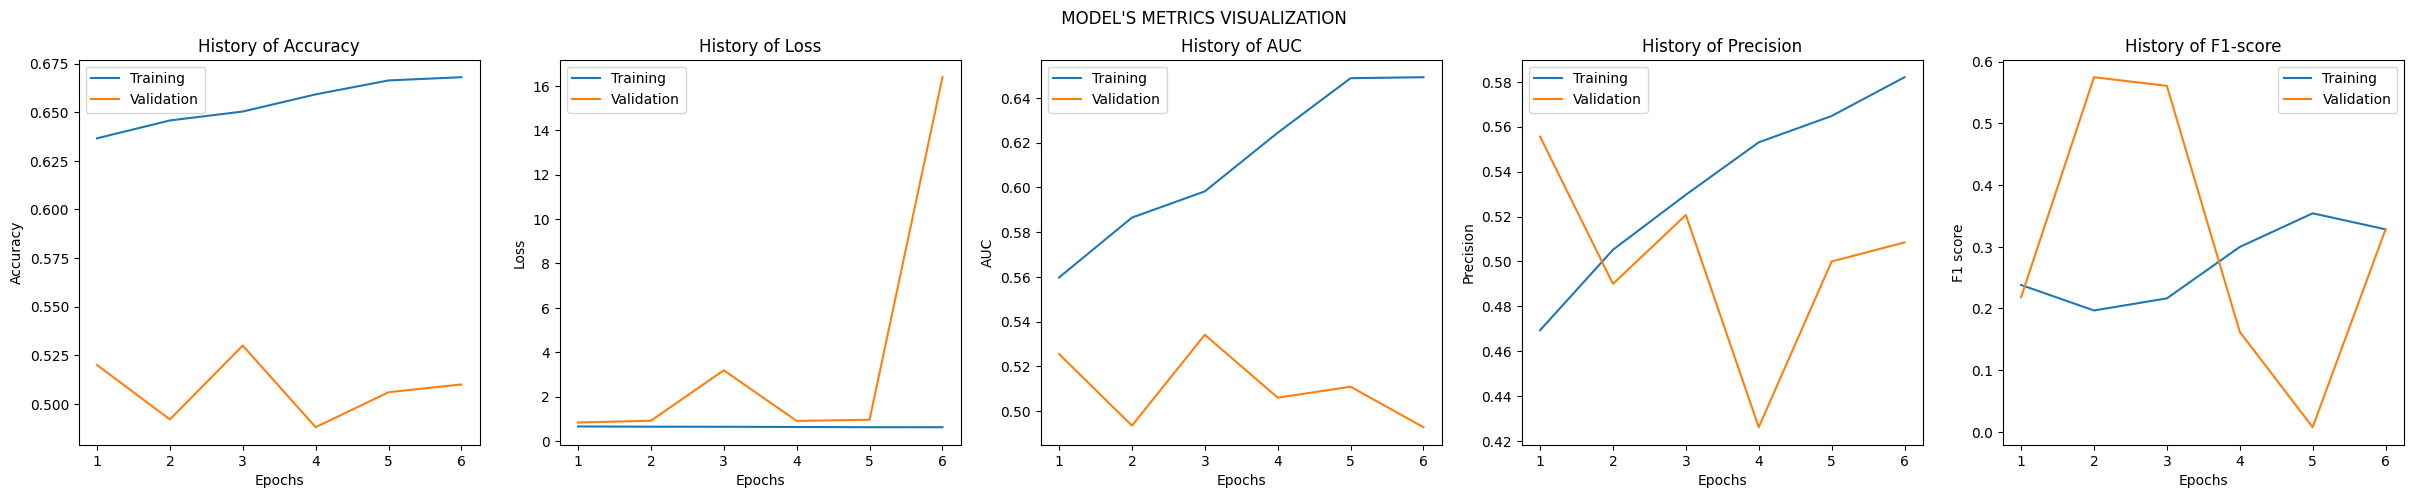

<Figure size 640x480 with 0 Axes>

In [129]:
Train_Val_Plot(XceptionNet_history.history['accuracy'],XceptionNet_history.history['val_accuracy'],
               XceptionNet_history.history['loss'],XceptionNet_history.history['val_loss'],
               XceptionNet_history.history['auc'],XceptionNet_history.history['val_auc'],
                XceptionNet_history.history['precision'],XceptionNet_history.history['val_precision'],
                XceptionNet_history.history['get_f1_score'],XceptionNet_history.history['val_get_f1_score'],'Xception'
              )

###6. Report the overall Accuracy, Precision, Recall, F-1 Score for the Test Set and report the class-wise Precision,Recall and F-1 Score for Test Set.


In [ ]:
#ResNet_load = tf.keras.models.load_model('/content/drive/MyDrive/DL/Assignments/A4/modelRes_Final.h5', custom_objects={"get_f1_score": get_f1_score,})

In [52]:
Xception_load = tf.keras.models.load_model('/content/drive/MyDrive/DL/Assignments/A4/modelXception_new_WD.h5', custom_objects={"get_f1_score": get_f1_score })

In [54]:
from sklearn.metrics import classification_report

In [55]:
def get_test_metric(test_model):
  res = []
  print('Predicting')
  y_pred = test_model.predict(test_Dataset) > 0.5
  print('Evaluating')
  np.where(y_pred>0.5,1,0)
  print('Evaluating')
  y_pred = y_pred.astype(int)
  res = test_model.evaluate(test_Dataset)
  print(classification_report(test_labels,y_pred))
  return res,y_pred

In [135]:
res2,y_pred_xcep = get_test_metric(Xception_load)

Predicting
16/16 [==============================] - 31s 2s/step
Evaluating
Evaluating
16/16 [==============================] - 34s 2s/step - loss: 15.7039 - accuracy: 0.5270 - precision: 0.5323 - recall: 0.2857 - auc: 0.5303 - get_f1_score: 0.3682
              precision    recall  f1-score   support

           0       0.51      0.76      0.61       510
           1       0.49      0.24      0.32       490

    accuracy                           0.50      1000
   macro avg       0.50      0.50      0.46      1000
weighted avg       0.50      0.50      0.47      1000



In [136]:
print(res2)

[15.70386028289795, 0.5270000100135803, 0.5323193669319153, 0.2857142984867096, 0.5303061604499817, 0.3681502938270569]


###7. Sub-sample to get the T-SNE Plots

###7.1 Sub-Sample

In [ ]:
import random

# Set the path to the directory for Test Set which is subdir_3
test_dir = "/content/drive/MyDrive/DL/Assignments/A4/Image_Data/subdir_3"
target_dir = "/content/drive/MyDrive/DL/Assignments/A4/"

# Set the number of images to sample from each label subdirectory
sample_size = 50

# This is the new directory to store sub-sampled images from each of the two labels as 0 and 1 respectively.
sample_dir = os.path.join(target_dir, "sample_data")
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

# Loop through the label directories as 0 and 1 in the Test Directory and randomly select 50 files to copy from each subdirectory.
for label in os.listdir(test_dir):
    # label_dir is to create label directories in the sub-sampled directory.
    label_dir = os.path.join(test_dir,label)
    label_sample_dir = os.path.join(sample_dir, label)
    if not os.path.exists(label_sample_dir):
        os.makedirs(label_sample_dir)
    # To list the files in the specific label sub-directory
    file_list = os.listdir(label_dir)
    sample_files = random.sample(file_list, sample_size)
    for file in sample_files:
        src = os.path.join(label_dir, file)
        dst = os.path.join(label_sample_dir, file)
        shutil.copy(src, dst)

print(f"{sample_size} files were sampled from each label subdirectory and copied to {sample_dir}")


50 files were sampled from each label subdirectory and copied to /content/drive/MyDrive/DL/Assignments/A4/sample_data


###7.2 Load the Data to DataLoader

In [53]:
sample_data_dir = '/content/drive/MyDrive/DL/Assignments/A4/sample_data'

In [ ]:
# sample_test_dataset = ImageFolder(sample_data_dir, transform=transform)
# sample_test_loader = DataLoader(sample_test_dataset, batch_size=my_batch_size, shuffle=False)

In [54]:
sample_test_generator = sample_test_datagen.flow_from_directory(
    sample_data_dir,
    target_size=(224, 224),
    batch_size=100,
    class_mode='binary'
)

Found 100 images belonging to 2 classes.


In [55]:
print(len(sample_test_generator.classes))

100


###7.3 Load the model and get the features

In [ ]:
# last_embedding_layer = nn.Sequential(*list(model.children())[:-1])

In [ ]:
# features = []

In [ ]:
# with torch.no_grad():
#     for inputs, _ in sample_test_loader:
#         inputs = inputs.to(device)
#         outputs = last_embedding_layer(inputs)
#         features.append(outputs.cpu().numpy())

In [56]:
Xception_load.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 dropout_14 (Dropout)        (None, 7, 7, 2048)        0         
                                                                 
 flatten_10 (Flatten)        (None, 100352)            0         
                                                                 
 batch_normalization_134 (Ba  (None, 100352)           401408    
 tchNormalization)                                               
                                                                 
 dense_32 (Dense)            (None, 32)                3211296   
                                                                 
 batch_normalization_135 (Ba  (None, 32)               128       
 tchNormalization)                                   

In [200]:
from tensorflow.keras.models import Model

embedding_model = Model(inputs=Xception_load.input, outputs=Xception_load.get_layer('dense_32').output)
# model = Xception
# embedding_model = Model(inputs=model.input, outputs=model.get_layer('block14_sepconv2_bn').output)

In [201]:
# model = Xception(weights='imagenet', include_top=False)

# layer_name = 'block14_sepconv2'

# model_extract = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

In [202]:
images, labels = next(iter(sample_test_generator))
images.shape

(100, 224, 224, 3)

In [203]:
# Assume that sample test generator in the batch.
batch = sample_test_generator.next()
images, labels = batch

In [204]:
print(labels)

[1. 0. 0. 1. 1. 0. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 1.
 1. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0. 0. 1. 0. 1. 0. 1. 1. 1. 0. 0. 1. 0.
 1. 1. 0. 0. 1. 1. 1. 0. 1. 1. 0. 1. 1. 0. 1. 0. 1. 1. 0. 0. 1. 0. 1. 1.
 1. 0. 0. 1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 0. 0. 0. 1. 1. 1. 1. 1. 0.
 1. 1. 0. 0.]


In [205]:
hateMemes = []
hateLessMemes = []

for i in range(len(labels)):
  if(labels[i]==0):
    hateMemes.append(images[i])
  elif(labels[i]==1):
    hateLessMemes.append(images[i])

In [206]:
print(len(hateMemes))
print(len(hateLessMemes))

50
50


In [207]:
hateMemes[0].shape

(224, 224, 3)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import load_model

# Load the model that can extract feature embeddings from images
model = embedding_model

# Define empty lists to store the feature embeddings
hateMemes_features = []
hateLessMemes_features = []
all_labels = []

# Extract feature embeddings for the images in hateMemes list
for i in range(len(hateMemes)):
    # Load the image and preprocess it for the model
    image = hateMemes[i]
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = image / 255.0

    # Extract the feature embedding for the image
    features = model.predict(image)

    # Append the feature embedding to the list
    hateMemes_features.append(features)

    all_labels.append(0)

# Extract feature embeddings for the images in hateLessMemes list
for i in range(len(hateLessMemes)):
    # Load the image and preprocess it for the model
    image = hateLessMemes[i]
    image = img_to_array(image)
    image = np.expand_dims(image, axis=0)
    image = image / 255.0

    # Extract the feature embedding for the image
    features = model.predict(image)

    # Append the feature embedding to the list
    hateLessMemes_features.append(features)

    all_labels.append(1)

# Concatenate the two lists of feature embeddings to get the feature embeddings of all 100 images
all_features = hateMemes_features + hateLessMemes_features


In [ ]:
#print(all_features)

In [197]:
# print(all_labels)

In [198]:
# print(len(all_features))

In [199]:
# # use squeeze function to remove empty dimensions
# #features = np.squeeze(test_features)

# # print the new shape of the array
# print(all_features[0])

In [220]:
print(len(hateMemes_features))

50


In [221]:
arr = np.array(hateMemes_features)

# Reshape the array to a new shape
new_hate_meme_features = arr.reshape(50,32)

In [222]:
arr = np.array(hateLessMemes_features)

# Reshape the array to a new shape
new_hate_less_meme_features = arr.reshape(50,32)

In [223]:
print(new_hate_meme_features[0])

[ 44.256252   81.5079    -30.623878   61.472397  -24.880133   35.985325
  41.59863    -1.6655966  42.309525   34.814873   31.328861  -43.30996
  53.566463  -42.581406   44.795322  -21.59438    57.93505    58.43062
  49.250435   12.845251   58.000446   52.84711    48.874043   52.07617
  47.979584   28.755964   51.544853   51.176495   21.245289  -44.468708
  55.317814   20.926321 ]


In [224]:
df_ps_1 = pd.DataFrame(new_hate_meme_features)
df_ps_2 = pd.DataFrame(new_hate_less_meme_features)

In [225]:
df_ps_1.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,44.256252,81.507896,-30.623878,61.472397,-24.880133,35.985325,41.598629,-1.665597,42.309525,34.814873,...,48.874043,52.076172,47.979584,28.755964,51.544853,51.176495,21.245289,-44.468708,55.317814,20.926321
1,44.264793,81.521461,-30.621378,61.496628,-24.879992,36.009232,41.617199,-1.653867,42.309422,34.808678,...,48.882790,52.101273,48.004349,28.753321,51.543800,51.171021,21.249762,-44.474213,55.331272,20.925367
2,44.426445,81.625816,-30.504730,61.710243,-24.766567,36.207428,41.705914,-1.521831,42.260693,34.678524,...,49.206161,52.315479,48.140388,28.639477,51.461109,51.089809,21.346891,-44.567520,55.491104,20.864803
3,44.469940,81.697243,-30.499008,61.777821,-24.756340,36.293354,41.736118,-1.489870,42.252319,34.650669,...,49.286358,52.384865,48.189774,28.596090,51.441345,51.058815,21.370438,-44.589390,55.561790,20.831350
4,44.339306,81.594398,-30.575882,61.609035,-24.829735,36.129116,41.660030,-1.585907,42.286095,34.748238,...,49.046272,52.221680,48.079247,28.681904,51.503273,51.122463,21.294504,-44.513439,55.428379,20.883646


In [227]:
df_ps_2.head()

,0,1,2,3,4,5,6,7,8,9,...,22,23,24,25,26,27,28,29,30,31
0,44.250229,81.501839,-30.627478,61.470692,-24.893541,35.979607,41.613544,-1.666654,42.317509,34.822289,...,48.852890,52.077450,47.991726,28.776815,51.556377,51.190788,21.234514,-44.473476,55.304592,20.941231
1,44.370567,81.630005,-30.571384,61.631725,-24.823881,36.148785,41.676571,-1.587113,42.289932,34.741299,...,49.075272,52.235027,48.088581,28.678421,51.498646,51.119072,21.305424,-44.524330,55.456455,20.874397
2,44.261509,81.505920,-30.609562,61.503292,-24.867285,36.027111,41.613155,-1.635290,42.305962,34.802452,...,48.910412,52.118675,47.996387,28.737892,51.542824,51.166107,21.250885,-44.479279,55.333477,20.923498
3,44.245327,81.514076,-30.640129,61.477505,-24.903540,35.995365,41.614548,-1.667055,42.321312,34.829536,...,48.850906,52.088516,47.992962,28.773569,51.562279,51.191532,21.230640,-44.471313,55.309093,20.943136
4,44.325733,81.521149,-30.540493,61.561974,-24.816027,36.052181,41.667023,-1.596996,42.275776,34.744320,...,49.000847,52.156197,48.047474,28.715763,51.500702,51.143944,21.297680,-44.505180,55.364227,20.910784


###7.4 T-SNE Algorithm to plot the Embedding

In [162]:
from sklearn.manifold import TSNE

In [228]:
# tsne = TSNE(n_components=2, perplexity=30, random_state=0)
# tsne_features = tsne.fit_transform(features)
tsne = TSNE(n_components=2,perplexity=40,verbose=1,random_state=0,n_iter=300)
tsne_features_hate = tsne.fit_transform(df_ps_1)
tsne_features_hateless = tsne.fit_transform(df_ps_2)

[t-SNE] Computing 49 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.000s...
[t-SNE] Computed neighbors for 50 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 0.500832
[t-SNE] KL divergence after 250 iterations with early exaggeration: 42.730240
[t-SNE] KL divergence after 300 iterations: 0.000416
[t-SNE] Computing 49 nearest neighbors...
[t-SNE] Indexed 50 samples in 0.000s...
[t-SNE] Computed neighbors for 50 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 50 / 50
[t-SNE] Mean sigma: 0.540215
[t-SNE] KL divergence after 250 iterations with early exaggeration: 39.283985
[t-SNE] KL divergence after 300 iterations: 0.000266


In [229]:
sample_test_labels = sample_test_generator.classes

In [230]:
print(sample_test_labels)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1
 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


In [232]:
zeros = []
ones = []
for i in range(len(sample_test_labels)):
  if sample_test_labels[i] == 0: zeros.append(sample_test_labels[i])
  else: ones.append(sample_test_labels[i])

In [234]:
ones

[1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1,
 1]

In [ ]:
# df = pd.DataFrame()
# df["Label"] = sample_test_labels
# df["comp-1"] = tsne_features[:,0]
# df["comp-2"] = tsne_features[:,1]
# print('PLOT')
# sns.scatterplot(x="comp-1", y="comp-2", hue='Label',
#                 palette=sns.color_palette("hls", 2),
#                 data=df).set(title="T-SNE for feature vectors") 

In [ ]:
# plt.scatter(tsne_features[sample_test_labels==0, 0], tsne_features[sample_test_labels==0, 1], label='Non-hateful')
# plt.scatter(tsne_features[sample_test_labels==1, 0], tsne_features[sample_test_labels==1, 1], label='Hateful')
# plt.legend()
# plt.show()

In [ ]:
# # Plot the T-SNE visualization
# plt.figure(figsize=(10, 8))
# plt.scatter(tsne_features[sample_test_labels == 1, 0], tsne_features[sample_test_labels == 1, 1], color='red', label='Hateful')
# plt.scatter(tsne_features[sample_test_labels == 0, 0], tsne_features[sample_test_labels == 0, 1], color='blue', label='Non-Hateful')
# plt.xlabel('TSNE Dimension 1')
# plt.ylabel('TSNE Dimension 2')
# plt.legend()
# plt.title('T-SNE Visualization of LSTM Features for Hateful vs. Non-Hateful')
# plt.show()

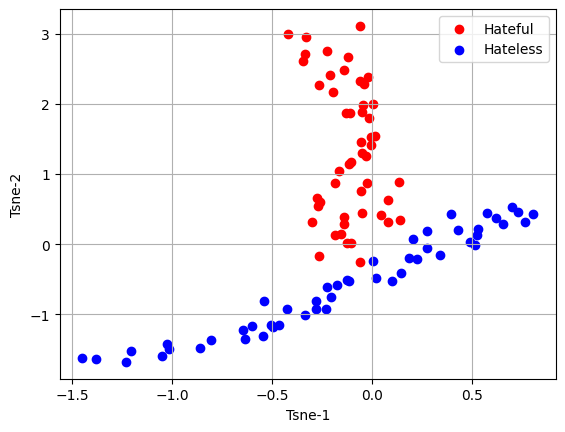

In [241]:
plt.scatter(tsne_features_hate[:,0],tsne_features_hate[:,1],c = 'red', label='Hateful')
plt.scatter(tsne_features_hateless[:,0],tsne_features_hateless[:,1],c = 'blue', label='Hateless')
plt.xlabel('Tsne-1')
plt.ylabel('Tsne-2')
plt.legend()
plt.grid()
plt.show()

### Share the Data

In [ ]:
df_list = pd.DataFrame(columns=['ID','Label'])

In [ ]:
#Iterate over the directory
file_ID = []
file_label = []
sample_dir = '/content/drive/MyDrive/DL/Assignments/A4/sample_data'
  # Loop through the label directories as 0 and 1 in the Test Directory and randomly select 50 files to copy from each subdirectory.
for label in os.listdir(sample_dir):
    # label_dir is to create label directories in the sub-sampled directory.
    label_dir = os.path.join(sample_dir,label)
    print(label_dir)
    file_list = os.listdir(label_dir)
    print(file_list)
    for i,file_name in enumerate(file_list):
      file_ID.append(file_name.split('.')[0])
      file_label.append(label.split('_')[1])

/content/drive/MyDrive/DL/Assignments/A4/sample_data/label_0
['01359.png', '74029.png', '18406.png', '46503.png', '64038.png', '02751.png', '74531.png', '43529.png', '42830.png', '93874.png', '29483.png', '64571.png', '80392.png', '28504.png', '50483.png', '76180.png', '39206.png', '61304.png', '07689.png', '42635.png', '75820.png', '93481.png', '21659.png', '32067.png', '69753.png', '52096.png', '13890.png', '84169.png', '04239.png', '13792.png', '76091.png', '10396.png', '94086.png', '76103.png', '62031.png', '57089.png', '69423.png', '96015.png', '45326.png', '87160.png', '27506.png', '83091.png', '29408.png', '29467.png', '23817.png', '27519.png', '16302.png', '74621.png', '40268.png', '57921.png']
/content/drive/MyDrive/DL/Assignments/A4/sample_data/label_1
['15079.png', '52140.png', '69421.png', '43506.png', '89461.png', '08567.png', '64730.png', '69308.png', '50162.png', '81690.png', '29547.png', '92601.png', '34602.png', '84670.png', '57286.png', '40728.png', '20781.png', '6241

In [ ]:
print(file_ID)
print(file_label)

['01359', '74029', '18406', '46503', '64038', '02751', '74531', '43529', '42830', '93874', '29483', '64571', '80392', '28504', '50483', '76180', '39206', '61304', '07689', '42635', '75820', '93481', '21659', '32067', '69753', '52096', '13890', '84169', '04239', '13792', '76091', '10396', '94086', '76103', '62031', '57089', '69423', '96015', '45326', '87160', '27506', '83091', '29408', '29467', '23817', '27519', '16302', '74621', '40268', '57921', '15079', '52140', '69421', '43506', '89461', '08567', '64730', '69308', '50162', '81690', '29547', '92601', '34602', '84670', '57286', '40728', '20781', '62418', '90845', '98137', '76913', '23751', '32789', '31805', '17805', '60289', '04615', '72430', '68749', '49215', '78092', '42936', '50176', '64735', '21849', '98637', '14602', '97456', '78936', '60721', '96082', '14375', '16598', '64279', '47903', '27496', '47265', '74813', '38765', '93251']
['0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0', '0'

In [ ]:
df_list['ID'] = pd.DataFrame(file_ID)
df_list['Label'] = pd.DataFrame(file_label)

In [ ]:
print(df_list)

       ID Label
0   01359     0
1   74029     0
2   18406     0
3   46503     0
4   64038     0
..    ...   ...
95  27496     1
96  47265     1
97  74813     1
98  38765     1
99  93251     1

[100 rows x 2 columns]


In [ ]:
df_list.to_pickle('/content/drive/MyDrive/DL/Assignments/A4/sample_details.pkl')